<a href="https://colab.research.google.com/github/MonseMontesBocanegra/Final_Project_Machine_Learning/blob/main/IntroToML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libaries and Dataset Loading Dataset

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
import kagglehub
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from torch import nn, optim

# Datasets
digit_dataset = kagglehub.dataset_download("hojjatk/mnist-dataset")
char_dataset = kagglehub.dataset_download("fayed02/handwritten-isolated-english-character-dataset")

print("Path to dataset files:", digit_dataset)
print("Path to dataset files:", char_dataset)

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

# Download and load the training data
trainset = datasets.MNIST('/root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/11', download=True, train=True, transform=transform)
valset = datasets.MNIST('/root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


NEURAL NETWORK (DIGITS)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [ 0.0055,  0.0055,  0.0055,  ...,  0.0055,  0.0055,  0.0055],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0035, -0.0035, -0.0035,  ..., -0.0035, -0.0035, -0.0035]])
Initial weights -  Parameter containing:
tensor([[ 0.0197, -0.0085, -0.0225,  ..., -0.0127,  0.0240,  0.0259],
        [-0.0239, -0.0128,  0.0070,  ...,  0.0002,  0.0136,  0.0046],
        [-0.0332,  0.0170,  0.0160,  ..., -0.0302, -0.0064,  0.0172],
        ...,
        [ 0.0274, -0.0016, -0.0155,  ...,  0.0212,  0.0109, -0.0276],
        [-0.0106, -0.0001, -0.0091,  ..., -0.0307, -0.0285, -0.0191],
        [-0.0335, -0.0356, -0.0277,  ...,  0.0228,  0.0134, -0.0233]],
       requires_grad=True)
Gradient - t

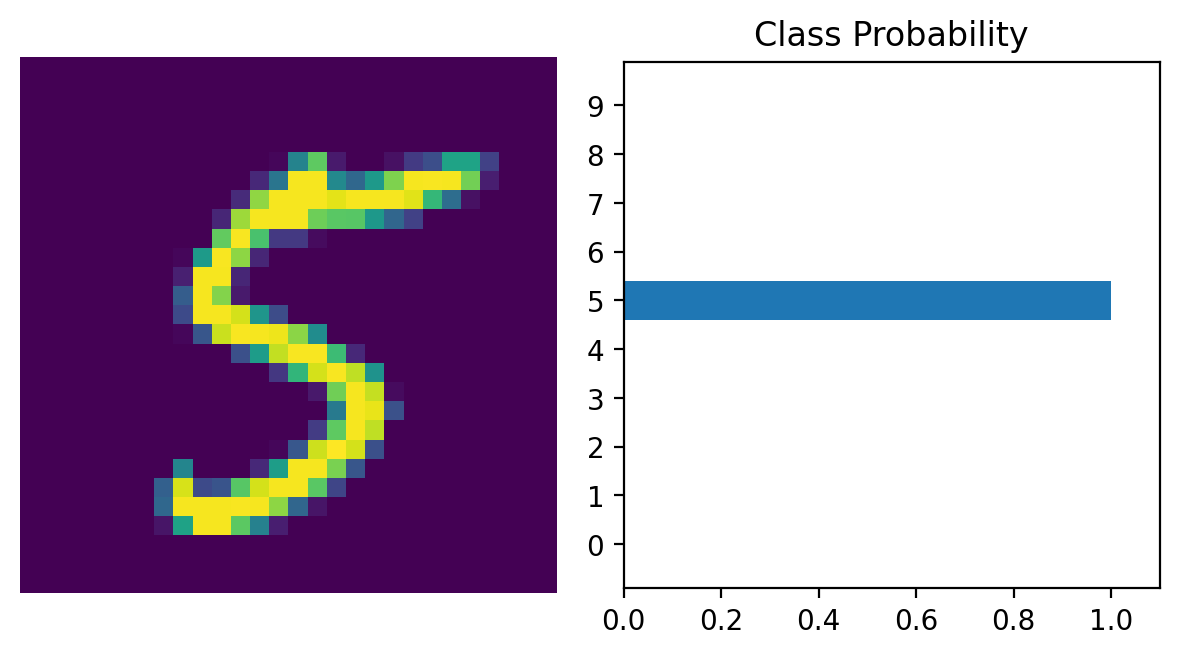

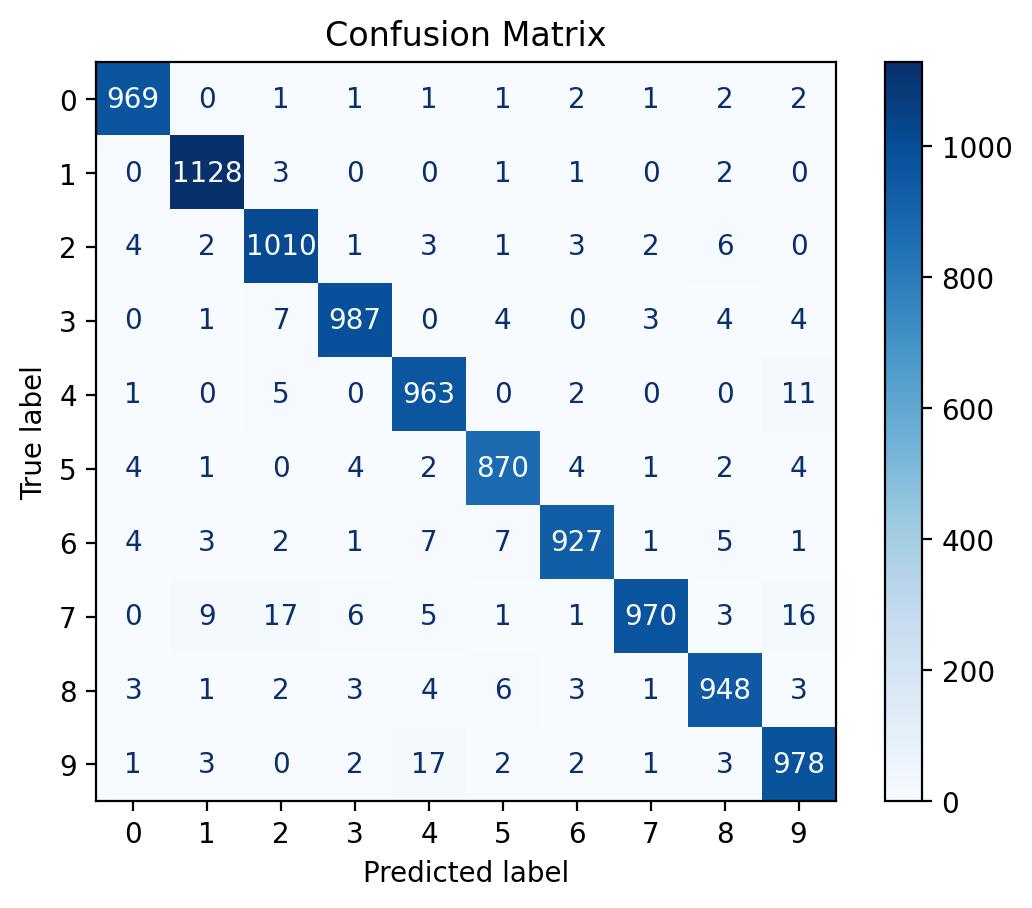

In [ ]:
# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        # This is where the model learns by backpropagating
        loss.backward()

        # And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes. '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

# Initialize variables for predictions and true labels
all_preds = []
all_labels = []

# Collect predictions and true labels
for images, labels in valloader:
    images = images.view(images.shape[0], -1)  # Flatten images
    with torch.no_grad():
        logps = model(images)
    ps = torch.exp(logps)  # Convert log-probabilities to probabilities
    preds = ps.argmax(dim=1)  # Get the index of the max probability
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Precision, Recall, F1-Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display the Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(10))
cmd.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

**NEURAL NETWORK (ALPHABET)**

Classes in the dataset: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Epoch 1 - Training loss: 0.6545
Epoch 2 - Training loss: 0.2873
Epoch 3 - Training loss: 0.2240
Epoch 4 - Training loss: 0.1814
Epoch 5 - Training loss: 0.1503
Epoch 6 - Training loss: 0.1293
Epoch 7 - Training loss: 0.1141
Epoch 8 - Training loss: 0.1004
Epoch 9 - Training loss: 0.0897
Epoch 10 - Training loss: 0.0814
Epoch 11 - Training loss: 0.0751
Epoch 12 - Training loss: 0.0683
Epoch 13 - Training loss: 0.0639
Epoch 14 - Training loss: 0.0571
Epoch 15 - Training loss: 0.0536

Training Time (in minutes) = 4.81253110965093
Predicted Class = 8 - eight
Number Of Images Tested = 10000

Model Accuracy = 0.9759

Precision: 0.9760
Recall: 0.9759
F1 Score: 0.9759


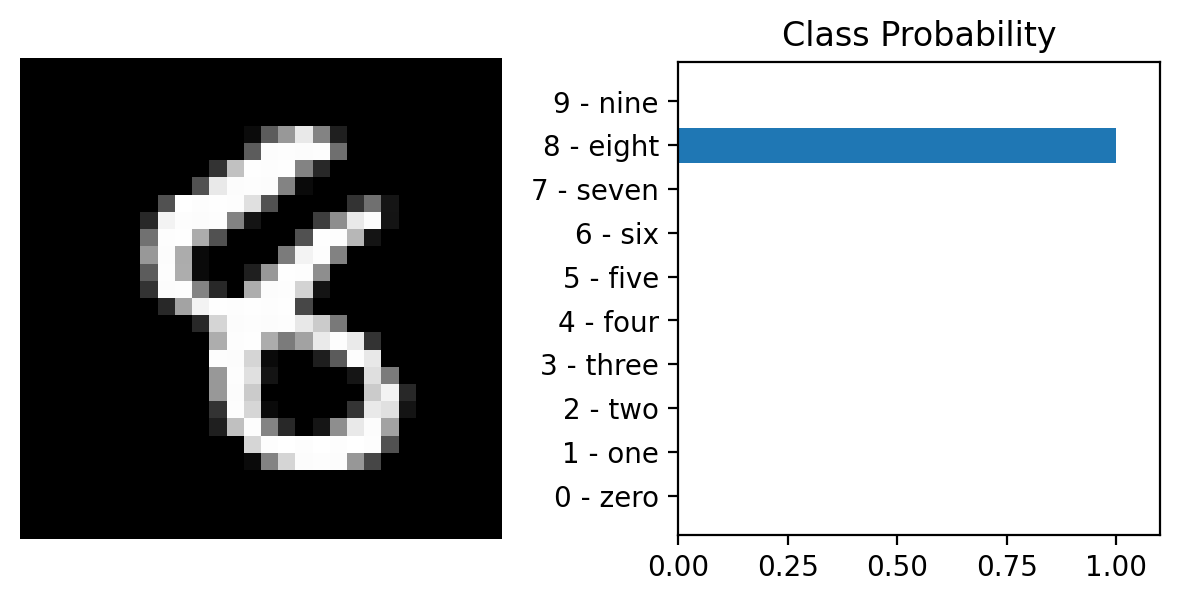

<Figure size 1200x600 with 0 Axes>

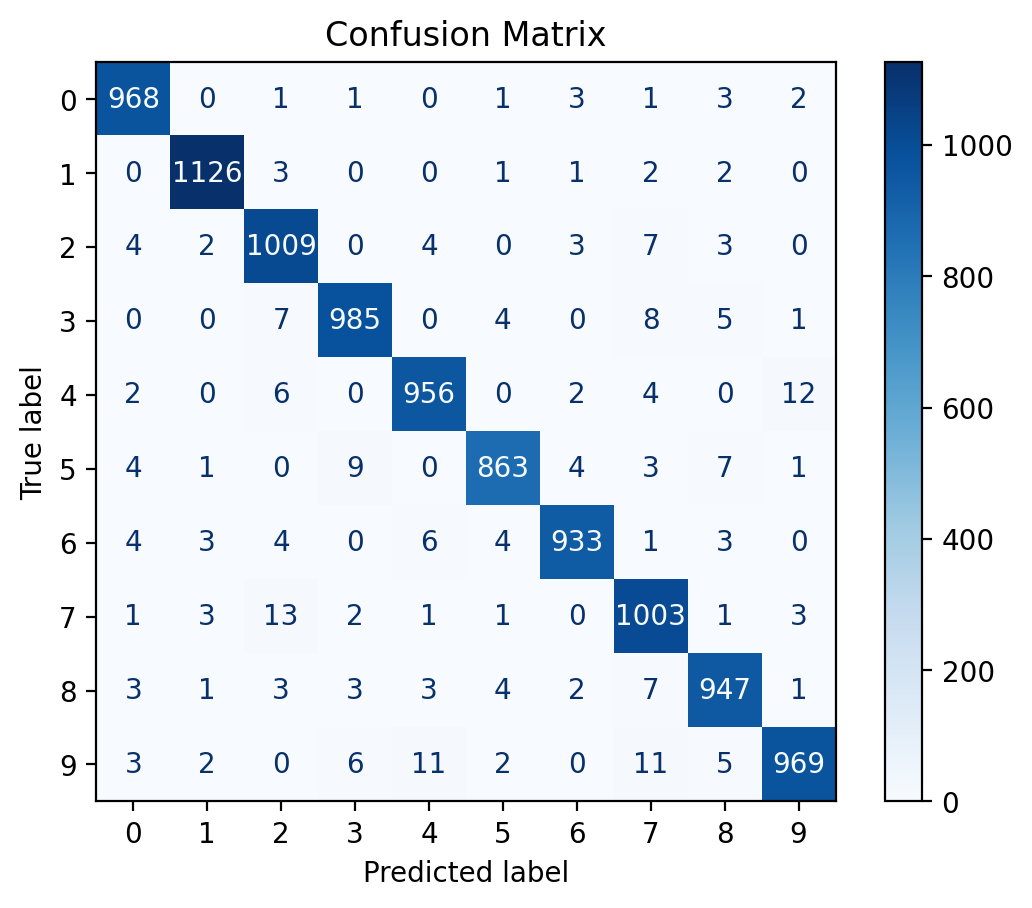

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Define transformations for the dataset
transform = transforms.Compose([transforms.Grayscale(), # Ensure grayscale images
                                transforms.Resize((28, 28)), # Resize to 28x28
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Display dataset information
print("Classes in the dataset:", trainset.classes)

# Adjust model for the alphabet dataset
input_size = 784  # 28x28 images
hidden_sizes = [128, 64]
output_size = len(trainset.classes)  # Number of classes in the dataset

# Build the neural network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

# Loss function
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Training loop
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten images into 1D vectors
        images = images.view(images.shape[0], -1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Epoch {e+1} - Training loss: {running_loss/len(trainloader):.4f}")
print("\nTraining Time (in minutes) =", (time() - time0) / 60)

# Function to view classification
def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes. '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(len(trainset.classes)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(trainset.classes)))
    ax2.set_yticklabels(trainset.classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# Validation
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Class =", trainset.classes[probab.index(max(probab))])
view_classify(img.view(1, 28, 28), ps)

# Model accuracy on validation data
correct_count, all_count = 0, 0
all_preds = []
all_labels = []
for images, labels in valloader:
    images = images.view(images.shape[0], -1)  # Flatten images
    with torch.no_grad():
        logps = model(images)
    ps = torch.exp(logps)  # Convert log-probabilities to probabilities
    preds = ps.argmax(dim=1)  # Get the index of the max probability
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    correct_count += (preds.cpu().numpy() == labels.cpu().numpy()).sum()
    all_count += labels.size(0)

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))

# Confusion Matrix and Metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Precision, Recall, F1-Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display the Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 6))
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(len(trainset.classes)))
cmd.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


BAYES CLASSIFIER (Digits)

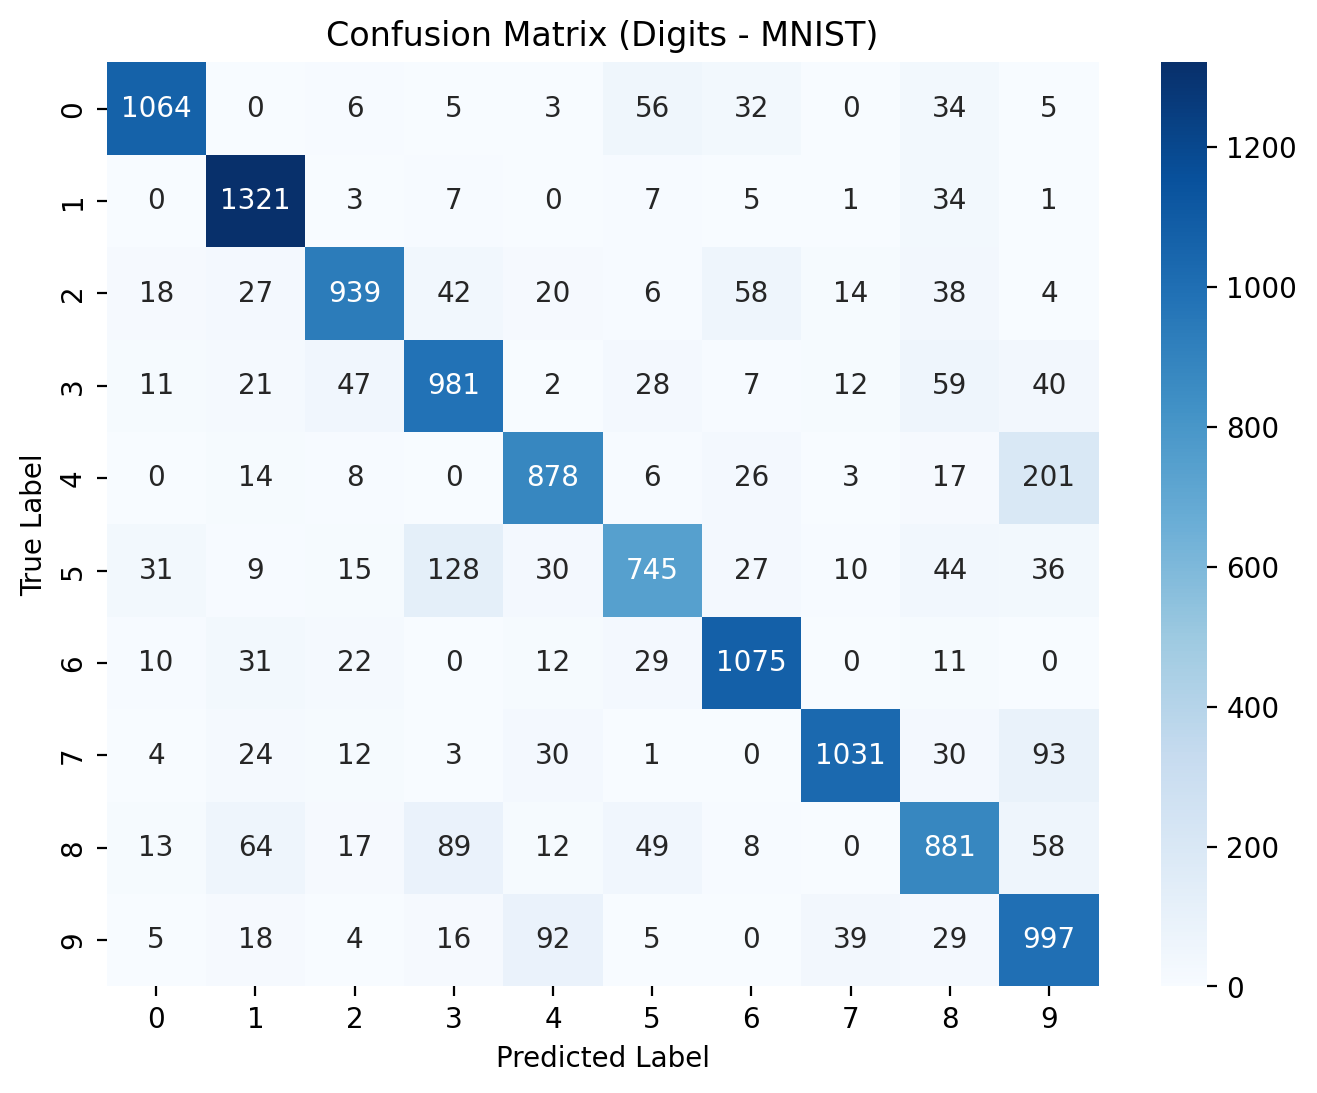

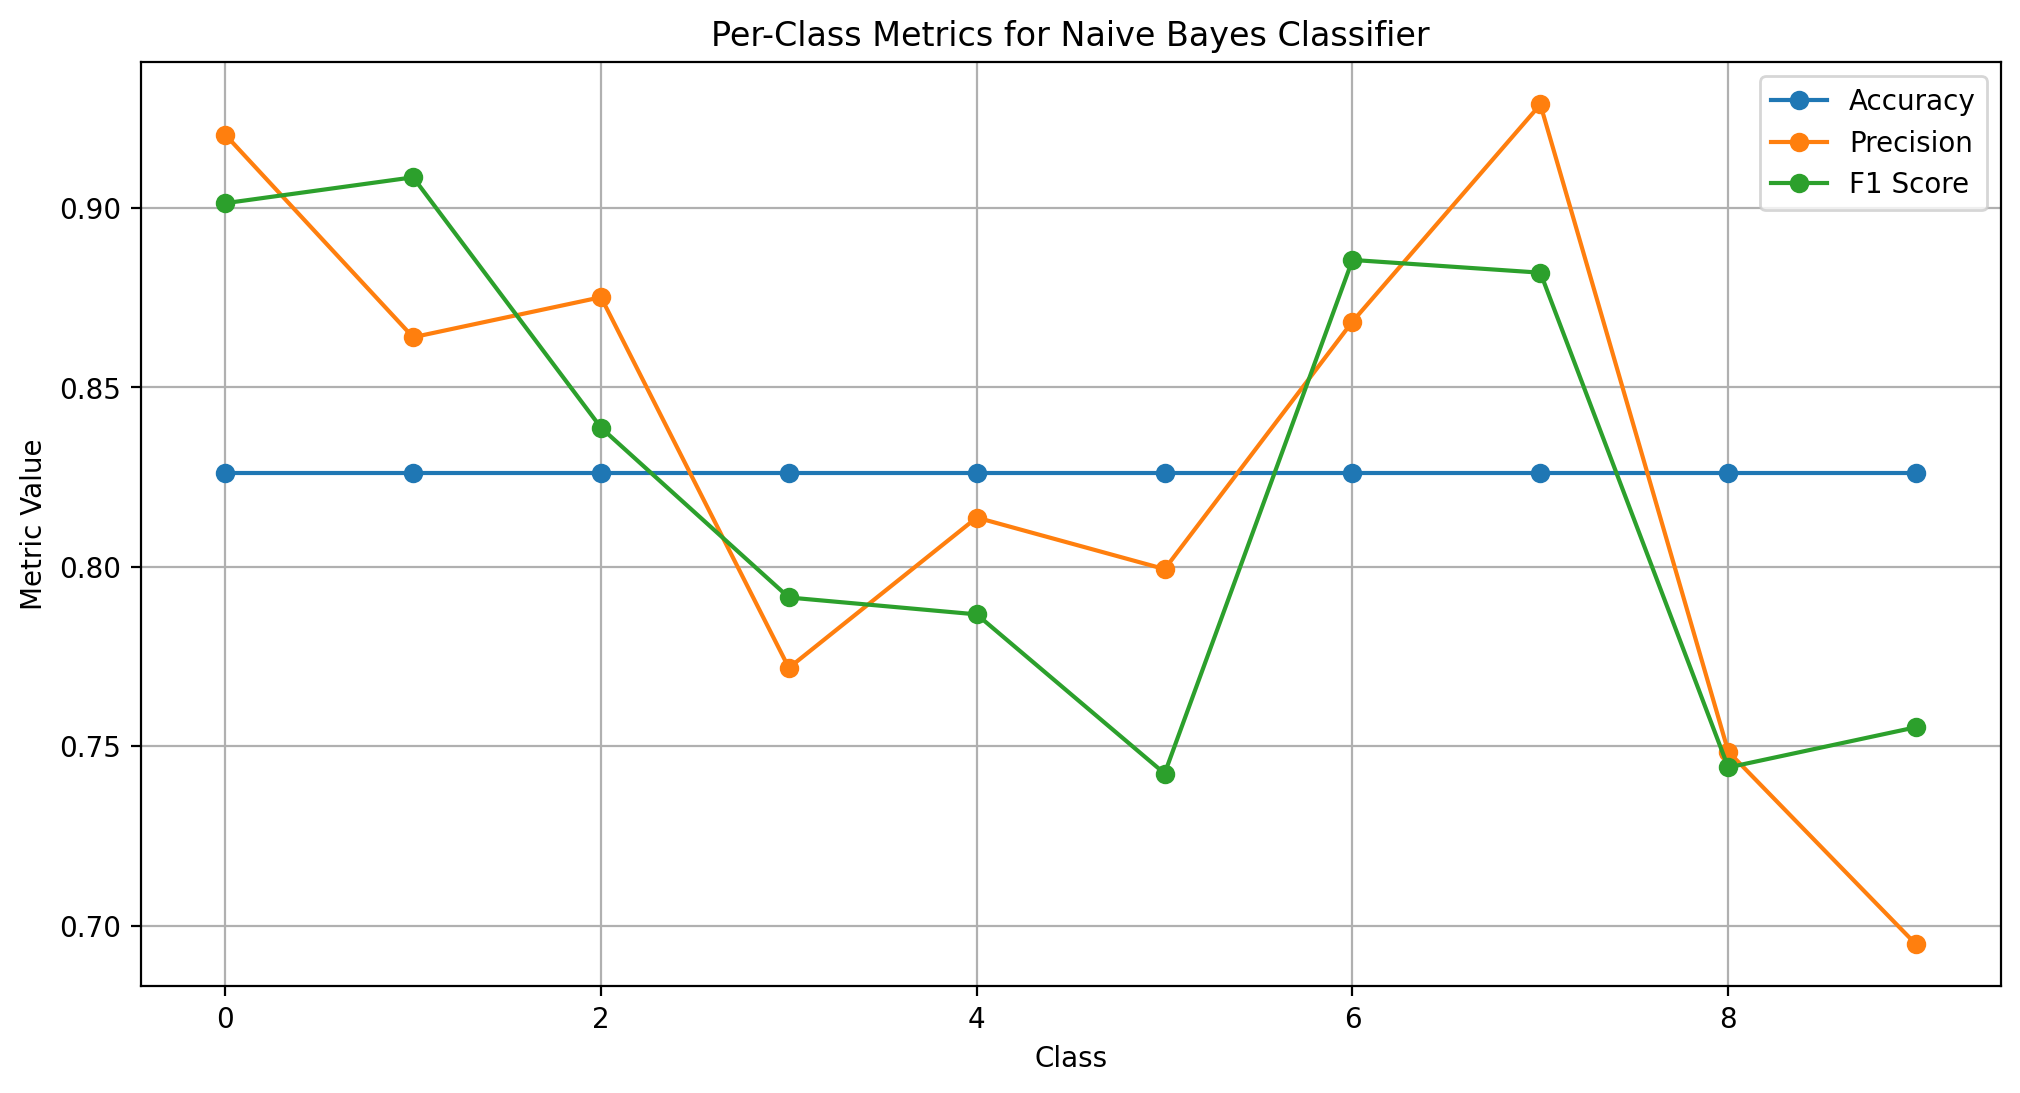


Classification Report (Digits):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1205
           1       0.86      0.96      0.91      1379
           2       0.88      0.81      0.84      1166
           3       0.77      0.81      0.79      1208
           4       0.81      0.76      0.79      1153
           5       0.80      0.69      0.74      1075
           6       0.87      0.90      0.89      1190
           7       0.93      0.84      0.88      1228
           8       0.75      0.74      0.74      1191
           9       0.69      0.83      0.76      1205

    accuracy                           0.83     12000
   macro avg       0.83      0.82      0.82     12000
weighted avg       0.83      0.83      0.83     12000

Digits Validation Accuracy: 82.60%

--- Averages ---
Macro Precision: 0.83
Macro Recall: 0.82
Macro F1-Score: 0.82
Weighted Precision: 0.83
Weighted Recall: 0.83
Weighted F1-Score: 0.83

Sample Predictions: D

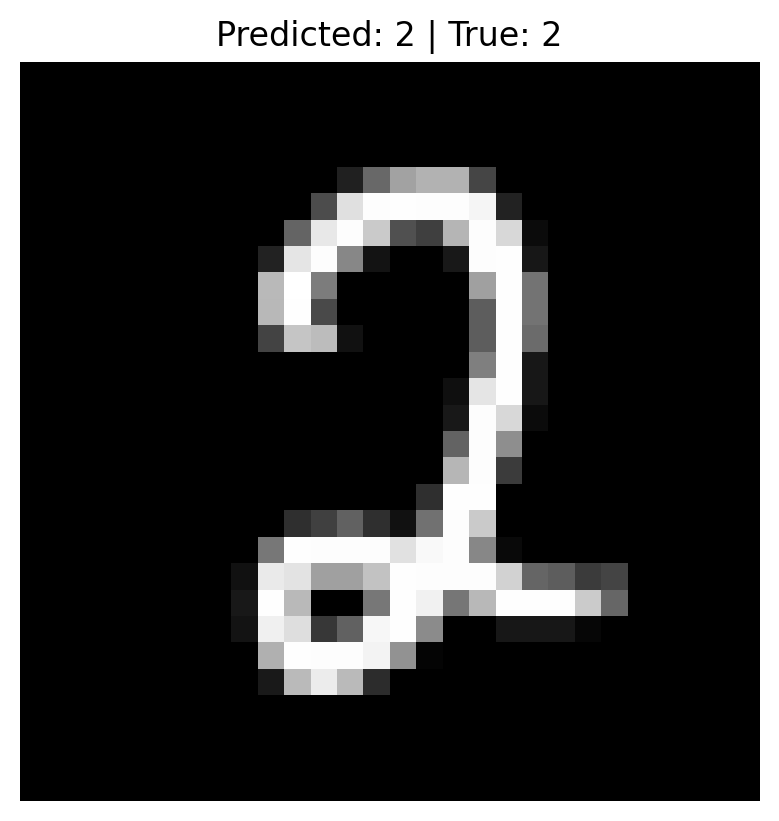

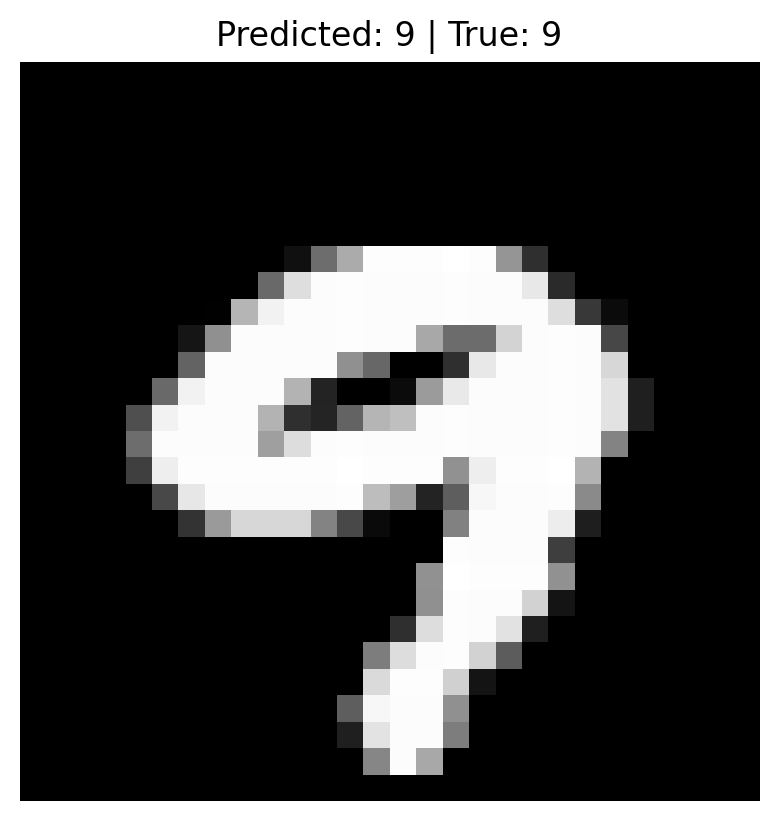

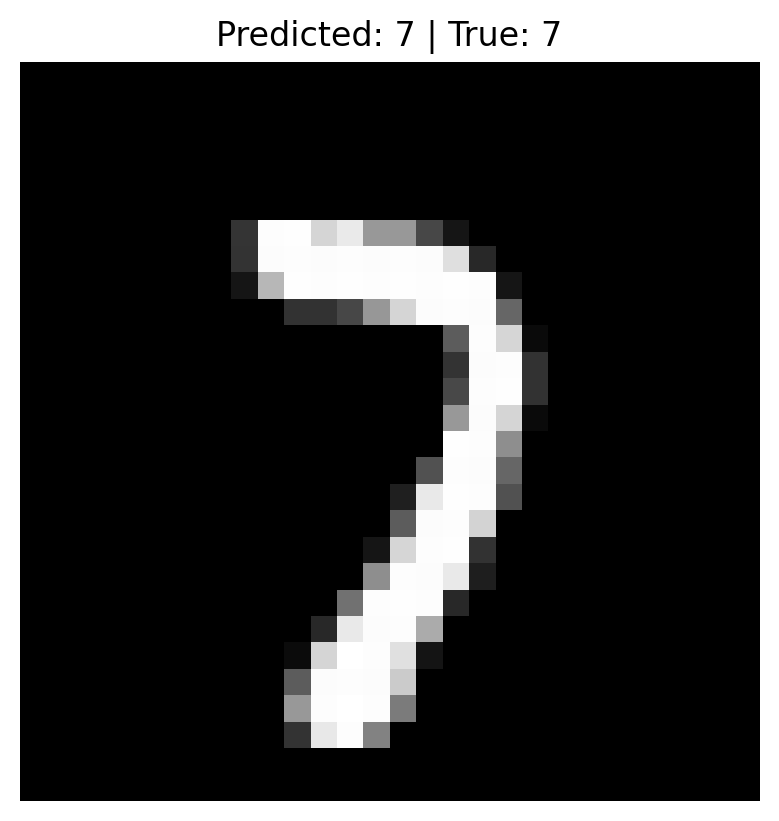

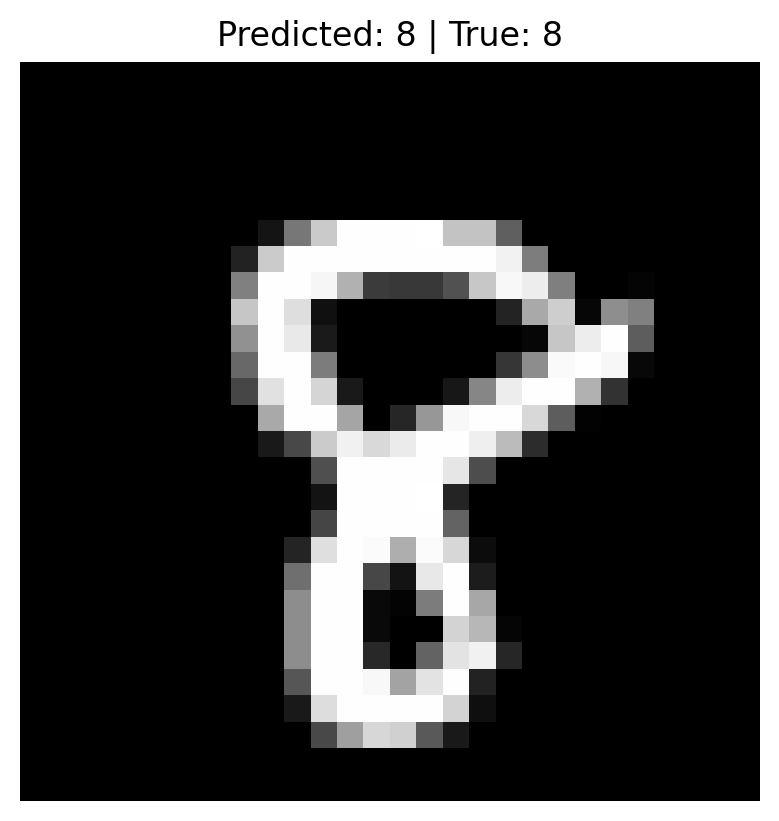

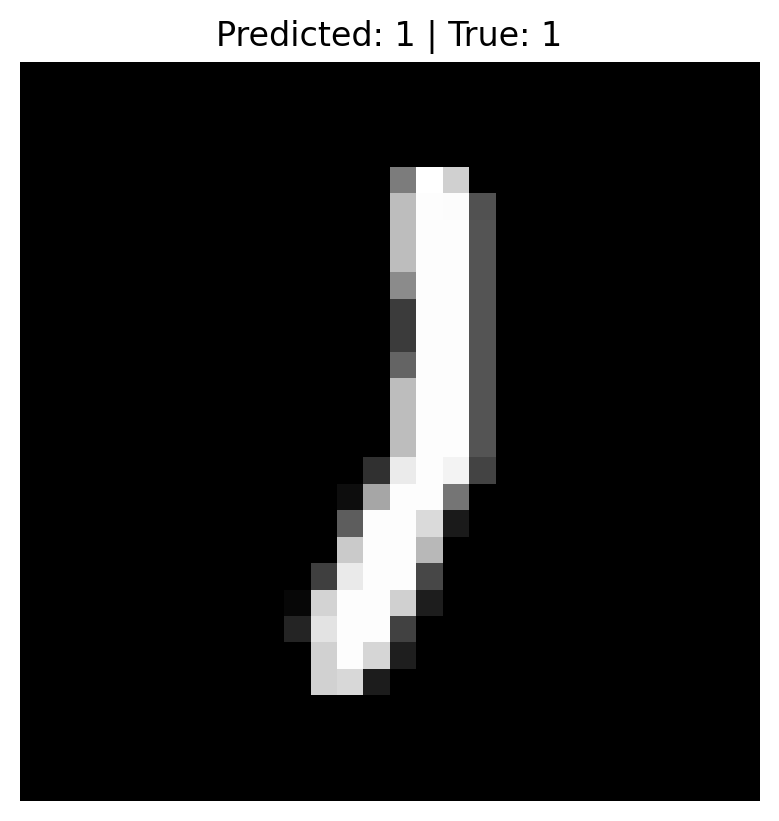

In [ ]:
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score

# Visualization function for predictions
def view_classify(img, pred_label, true_label):
    ''' Visualizes an image and its predicted and true classes. '''
    img = img.reshape(28, 28)  # Reshape to 28x28
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {pred_label} | True: {true_label}")
    plt.axis('off')
    plt.show()

# Function to visualize confusion matrix
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Common transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Flatten images and extract labels
X = trainset.data.view(-1, 28 * 28).numpy().astype(np.float32)
y = trainset.targets.numpy()

# Normalize pixel values to [0, 1]
X = X / 255.0

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Normalize using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Bernoulli Naive Bayes model
digit_classifier = BernoulliNB(alpha=0.1)
digit_classifier.fit(X_train_scaled > 0.5, y_train)  # Binarize for BernoulliNB

# Evaluate the model
digit_val_predictions = digit_classifier.predict(X_test_scaled > 0.5)
digit_accuracy = accuracy_score(y_test, digit_val_predictions)

# Confusion matrix
digit_conf_matrix = confusion_matrix(y_test, digit_val_predictions)
plot_confusion_matrix(digit_conf_matrix, classes=list(range(10)), title="Confusion Matrix (Digits - MNIST)")

# Generate detailed classification metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, digit_val_predictions, average=None)

# Macro (unweighted) averages
macro_precision = precision.mean()
macro_recall = recall.mean()
macro_f1 = f1.mean()

# Weighted averages
weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

# Plot metrics for each class
classes = list(range(10))  # Define classes for digits 0-9
plt.figure(figsize=(12, 6))
plt.plot(classes, [digit_accuracy] * len(classes), label='Accuracy', marker='o') #Using digit accuracy for now
plt.plot(classes, precision, label='Precision', marker='o')
plt.plot(classes, f1, label='F1 Score', marker='o')
#plt.xticks(classes, labels=[chr(i + 96) for i in classes])  # Convert classes to letters (removed for digits)
plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title('Per-Class Metrics for Naive Bayes Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
print("\nClassification Report (Digits):")
print(classification_report(y_test, digit_val_predictions))
print(f"Digits Validation Accuracy: {digit_accuracy * 100:.2f}%")

print("\n--- Averages ---")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1-Score: {macro_f1:.2f}")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")

# Visualize sample predictions for Digits
print("\nSample Predictions: Digits:")
for i in np.random.choice(len(X_test), size=5, replace=False):  # Display 5 predictions
    img = X_test[i].reshape(1, -1)
    pred_label = digit_classifier.predict(img > 0.5)[0]
    true_label = y_test[i]
    view_classify(X_test[i].reshape(1, 28, 28), pred_label, true_label)

BAYES CLASSIFIER (Alphabet)

100%|██████████| 562M/562M [00:12<00:00, 45.6MB/s]


Extracting /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1/EMNIST/raw/gzip.zip to /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1/EMNIST/raw
Validation Accuracy: 57.83%
Precision: 0.58
Recall: 0.58
F1 Score: 0.57


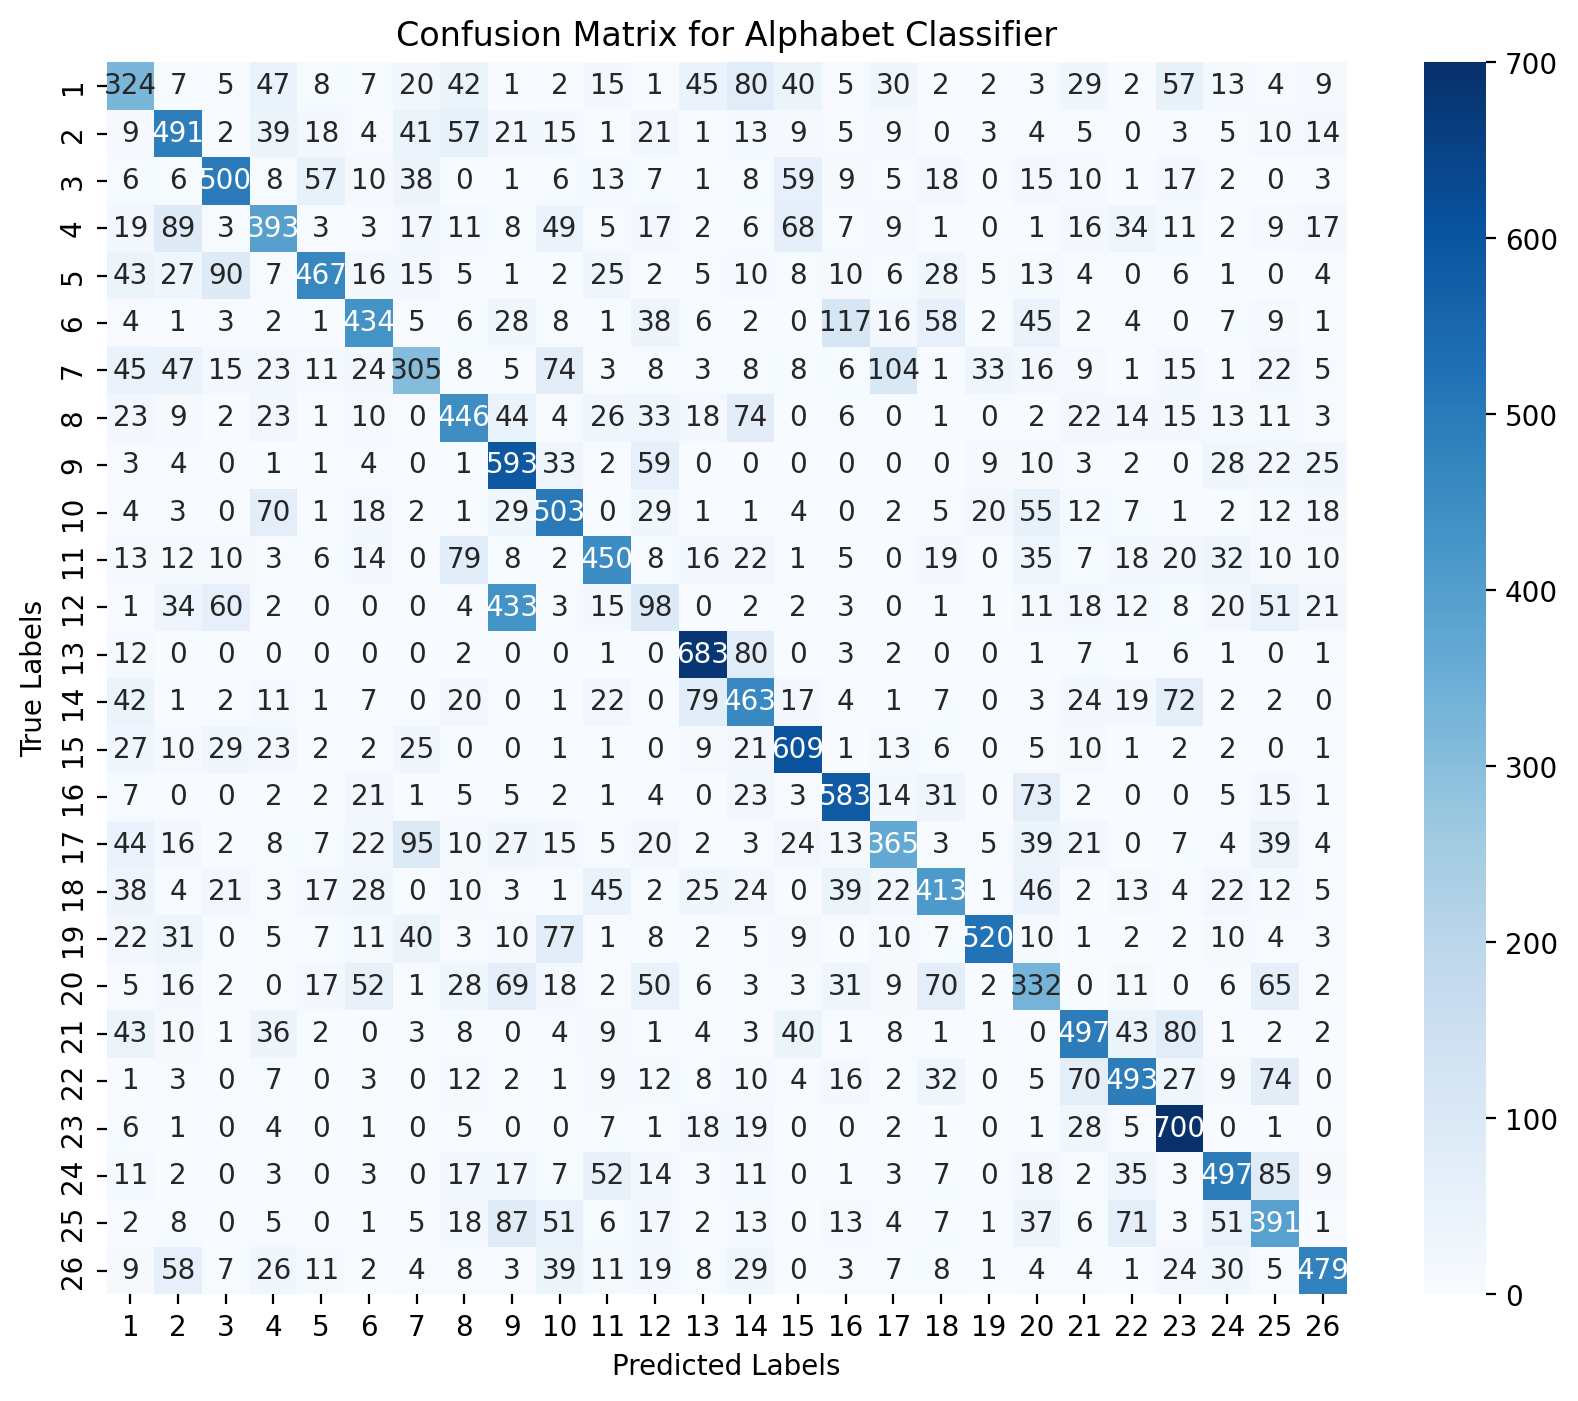

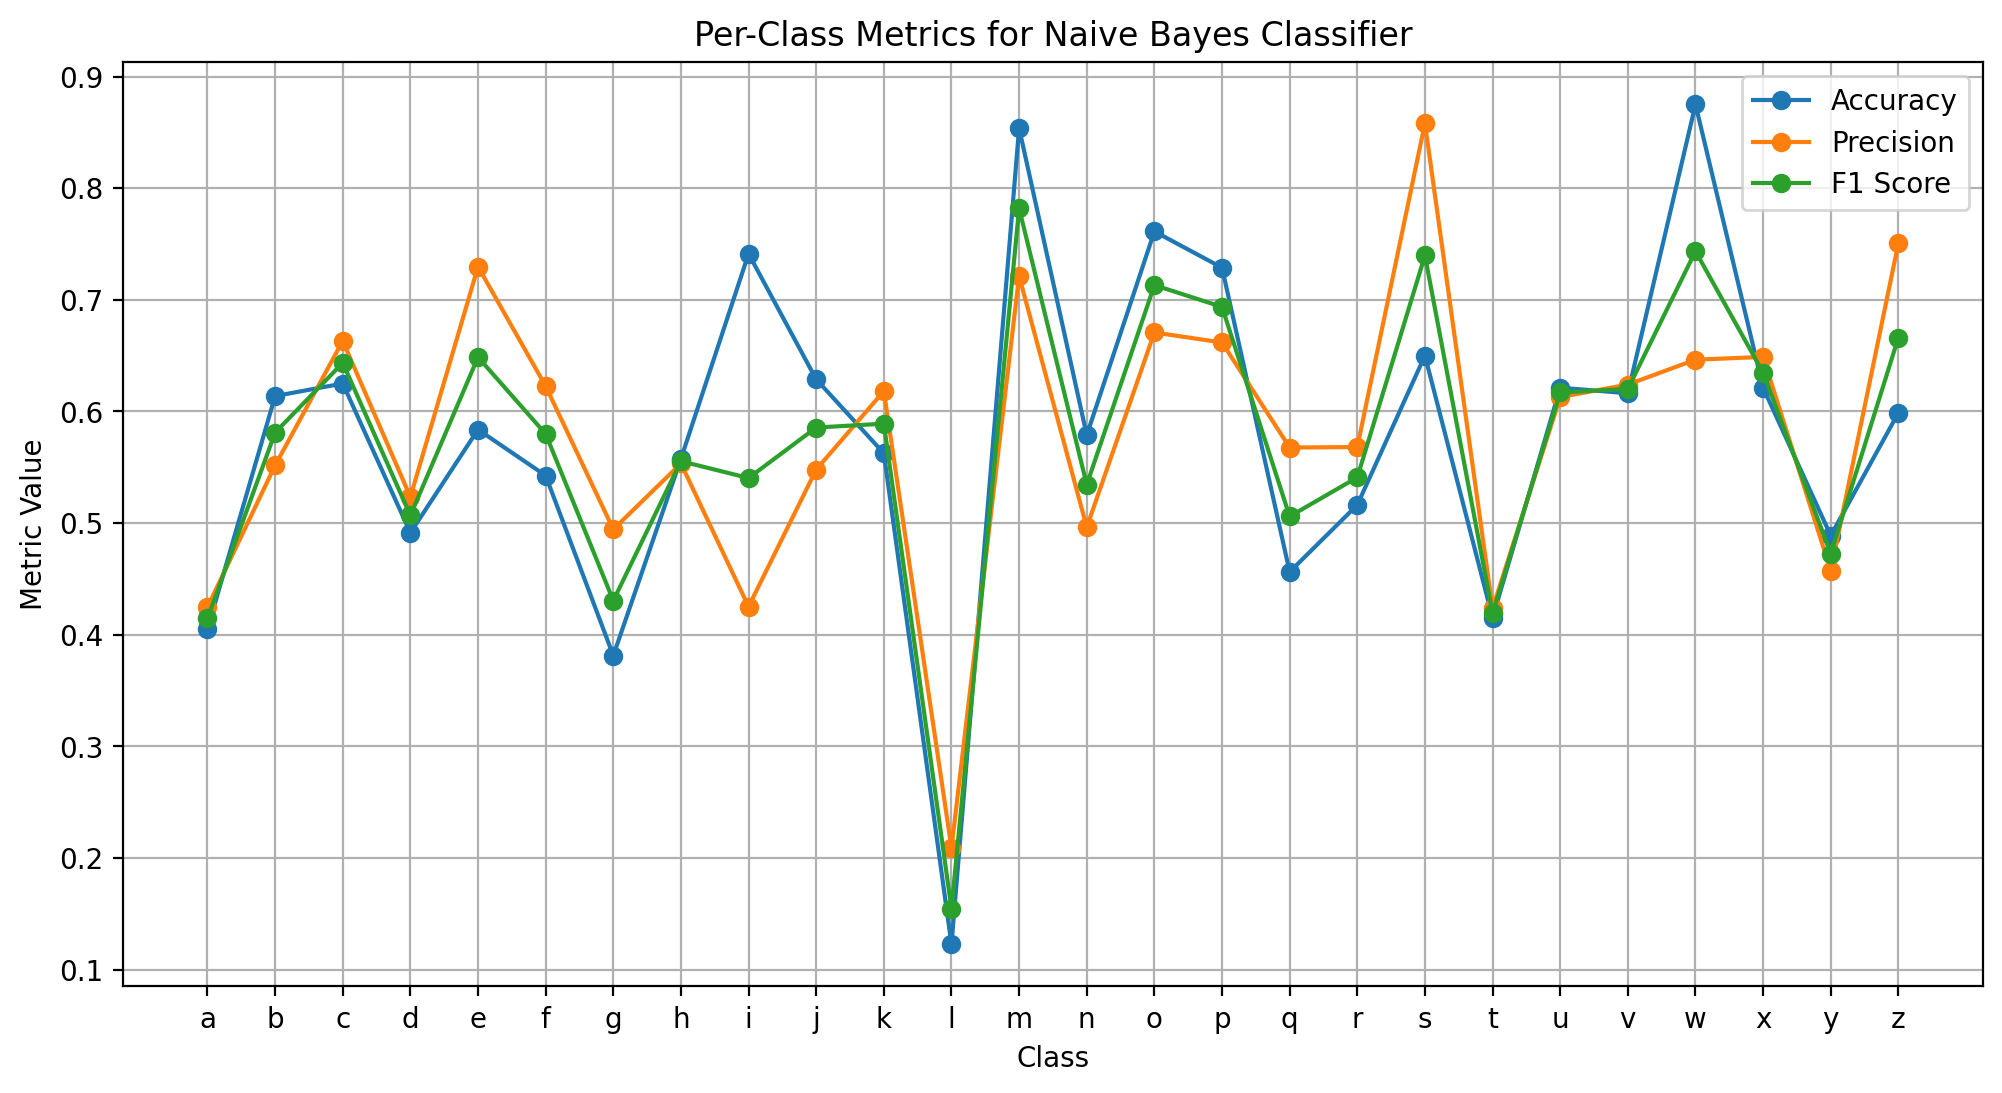

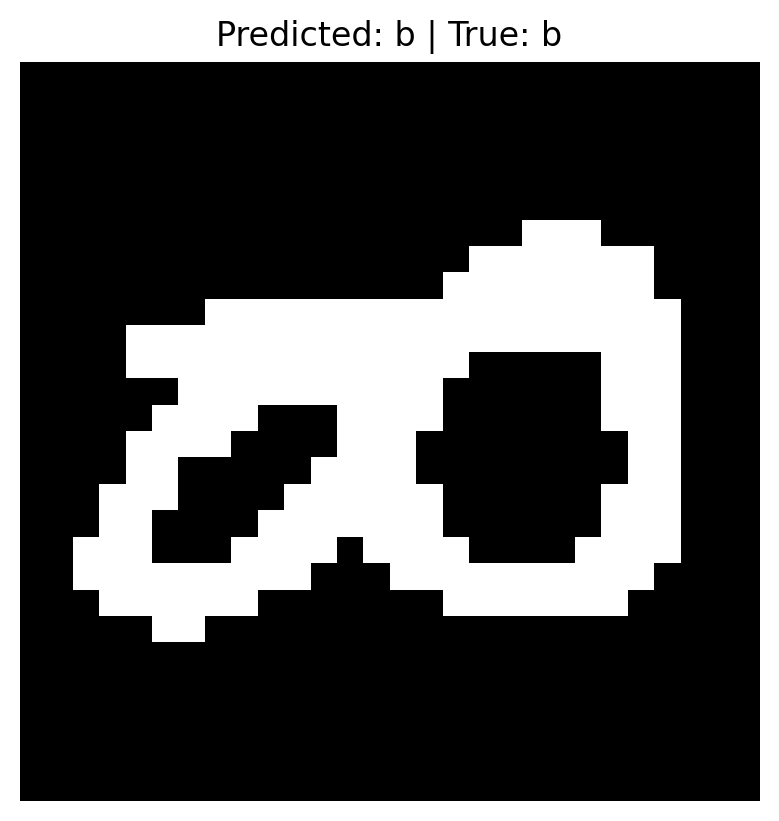

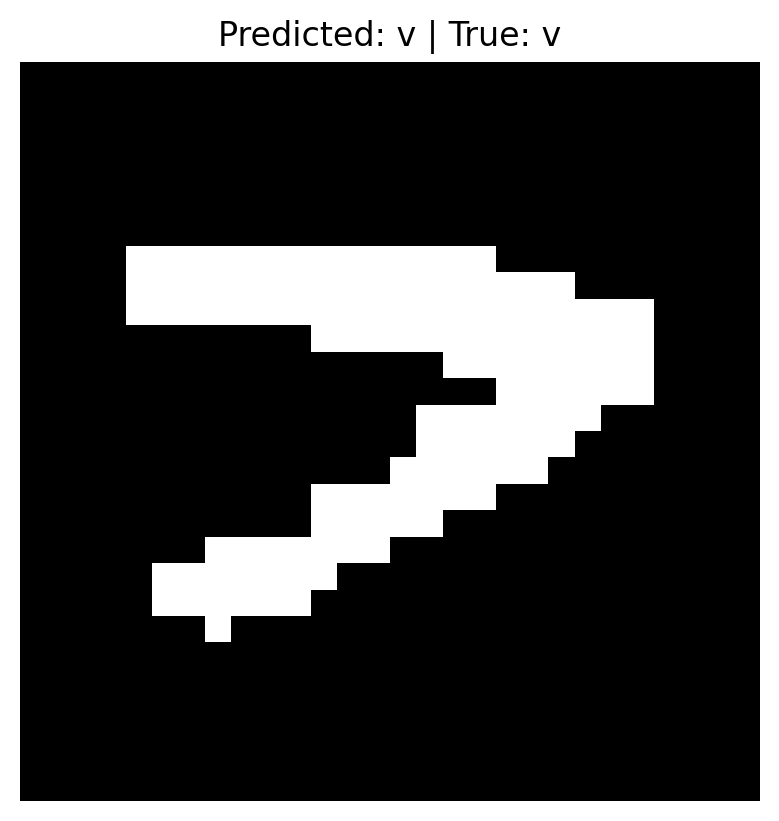

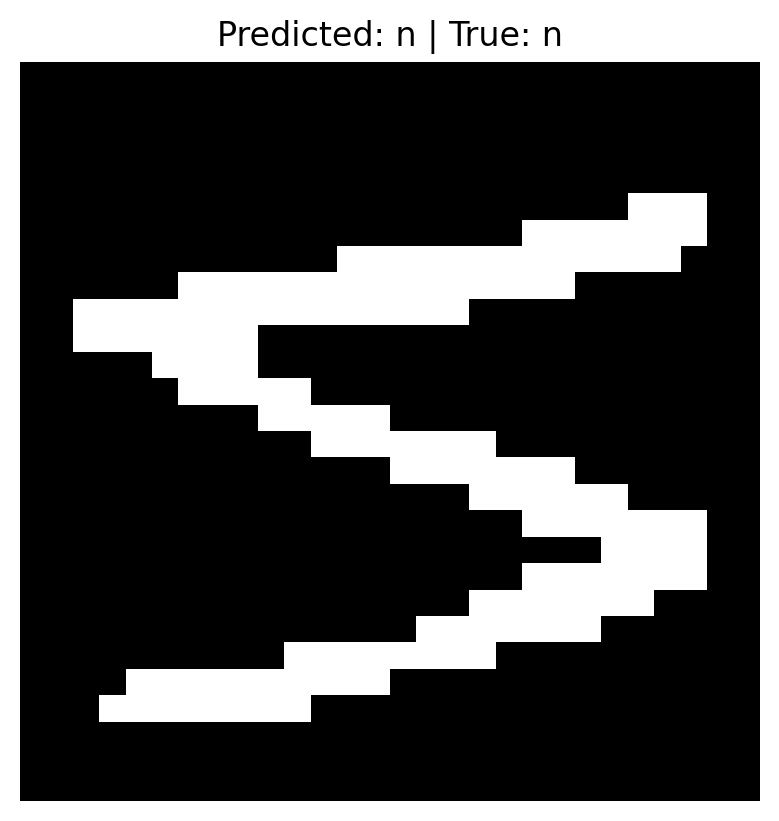

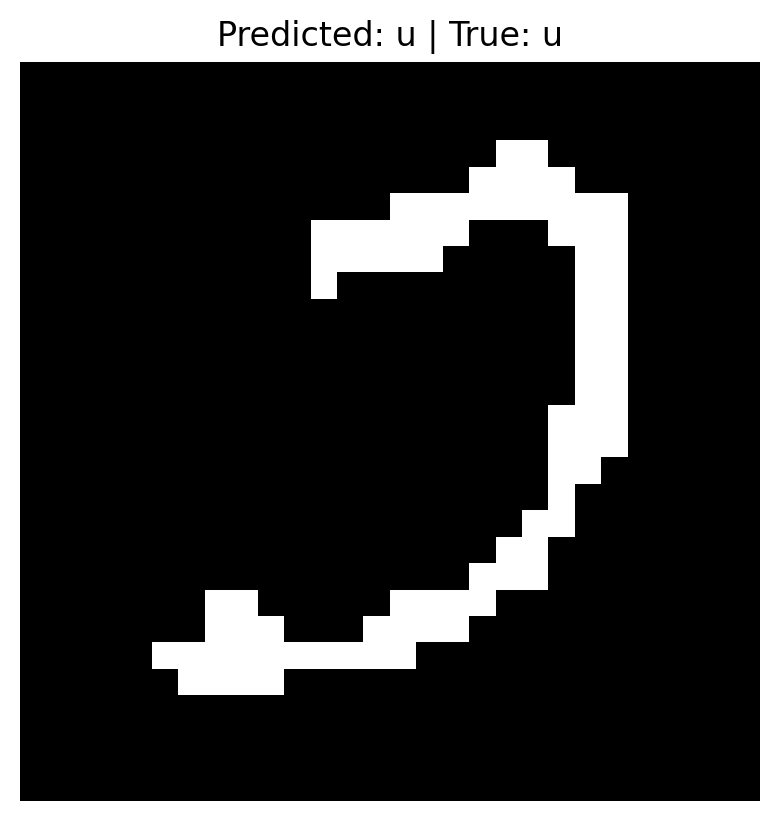

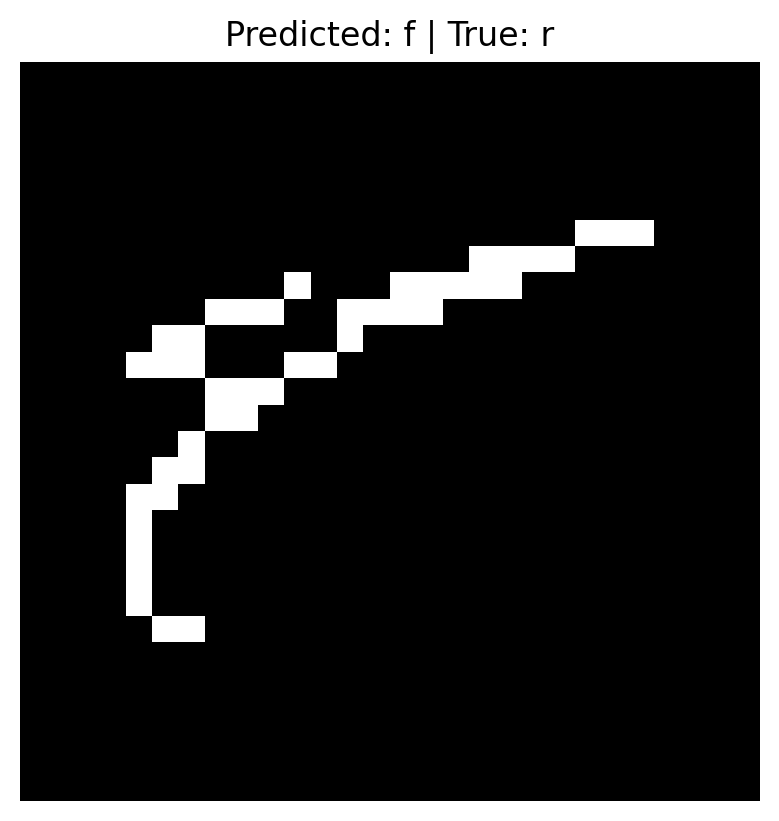

In [ ]:
# Visualize Predictions
def view_classify(img, pred_label, true_label):
    ''' Function for viewing an image and its predicted class. '''
    img = img.reshape(28, 28)  # Reshape to 28x28
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {chr(pred_label + 96)} | True: {chr(true_label + 96)}")
    plt.axis('off')
    plt.show()

# Preprocess the data (Binarize Pixel & Flatten Image)
def preprocess_data(loader, binarize=True):
    data = []
    labels = []
    for images, targets in loader:
        images = images.view(images.shape[0], -1).numpy()  # Flatten images (28x28 -> 784)
        if binarize:
            images = (images > 0.5).astype(np.float32)  # Binarize pixel values
        targets = targets.numpy()
        data.append(images)
        labels.append(targets)
    return np.vstack(data), np.hstack(labels)

# Download and preprocess data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load alphabet dataset
alphabet_dataset_path = "/root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1"
trainset = datasets.EMNIST(alphabet_dataset_path, split="letters", train=True, download=True, transform=transform)
valset = datasets.EMNIST(alphabet_dataset_path, split="letters", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

train_data, train_labels = preprocess_data(trainloader, binarize=True)
val_data, val_labels = preprocess_data(valloader, binarize=True)

# Train Naive Bayes Classifier
classifier = BernoulliNB(alpha=0.5)  # Smoothing parameter
classifier.fit(train_data, train_labels)

# Test the classifier
val_predictions = classifier.predict(val_data)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_predictions, average='macro')
recall = recall_score(val_labels, val_predictions, average='macro')
f1 = f1_score(val_labels, val_predictions, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 27), yticklabels=range(1, 27))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Alphabet Classifier")
plt.show()

# Calculate metrics for each class
class_accuracies = []
class_precisions = []
class_f1_scores = []
classes = range(1, 27)  # EMNIST "letters" classes range from 1 to 26

for c in classes:
    # Get indices for the current class
    true_positive = (val_labels == c)
    predicted_positive = (val_predictions == c)

    # Accuracy for the current class
    class_accuracy = np.mean(predicted_positive[true_positive]) if np.any(true_positive) else 0
    class_accuracies.append(class_accuracy)

    # Precision and F1 score for the current class
    precision = precision_score(val_labels, val_predictions, labels=[c], average='macro', zero_division=0)
    f1 = f1_score(val_labels, val_predictions, labels=[c], average='macro', zero_division=0)

    class_precisions.append(precision)
    class_f1_scores.append(f1)

# Calculate averages
average_accuracy = np.mean(class_accuracies)
average_precision = np.mean(class_precisions)
average_f1_score = np.mean(class_f1_scores)

# Plot metrics for each class
plt.figure(figsize=(12, 6))
plt.plot(classes, class_accuracies, label='Accuracy', marker='o')
plt.plot(classes, class_precisions, label='Precision', marker='o')
plt.plot(classes, class_f1_scores, label='F1 Score', marker='o')
plt.xticks(classes, labels=[chr(i + 96) for i in classes])  # Convert classes to letters
plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title('Per-Class Metrics for Naive Bayes Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Show sample predictions
images, labels = next(iter(valloader))
images = images.view(images.shape[0], -1).numpy()
images = (images > 0.5).astype(np.float32)  # Binarize for consistency
for i in range(5):  # Show 5 examples
    pred_label = classifier.predict([images[i]])[0]
    true_label = labels[i].item()
    view_classify(images[i].reshape(1, 28, 28), pred_label, true_label)

SUPPORT VECTOR MACHINE

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.94MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1185
           1       0.95      0.98      0.96      1348
           2       0.88      0.90      0.89      1192
           3       0.89      0.90      0.89      1226
           4       0.93      0.92      0.92      1168
           5       0.89      0.89      0.89      1084
           6       0.96      0.95      0.96      1184
           7       0.94      0.92      0.93      1253
           8       0.90      0.87      0.89      1170
           9       0.93      0.90      0.91      1190

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000

Accuracy: 0.9218333333333333


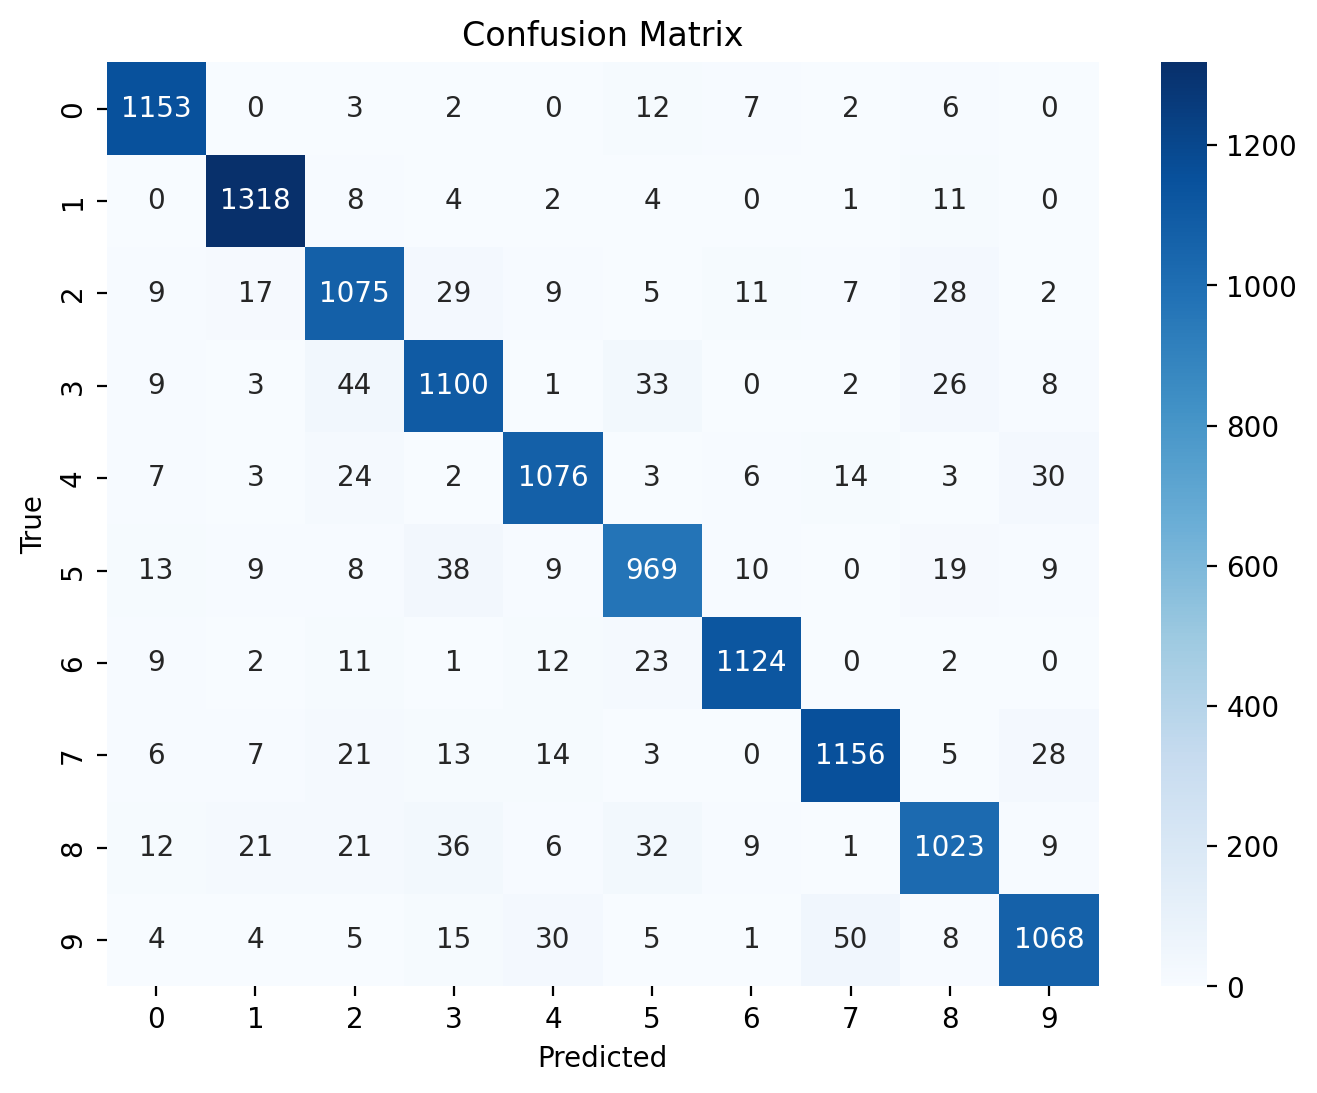

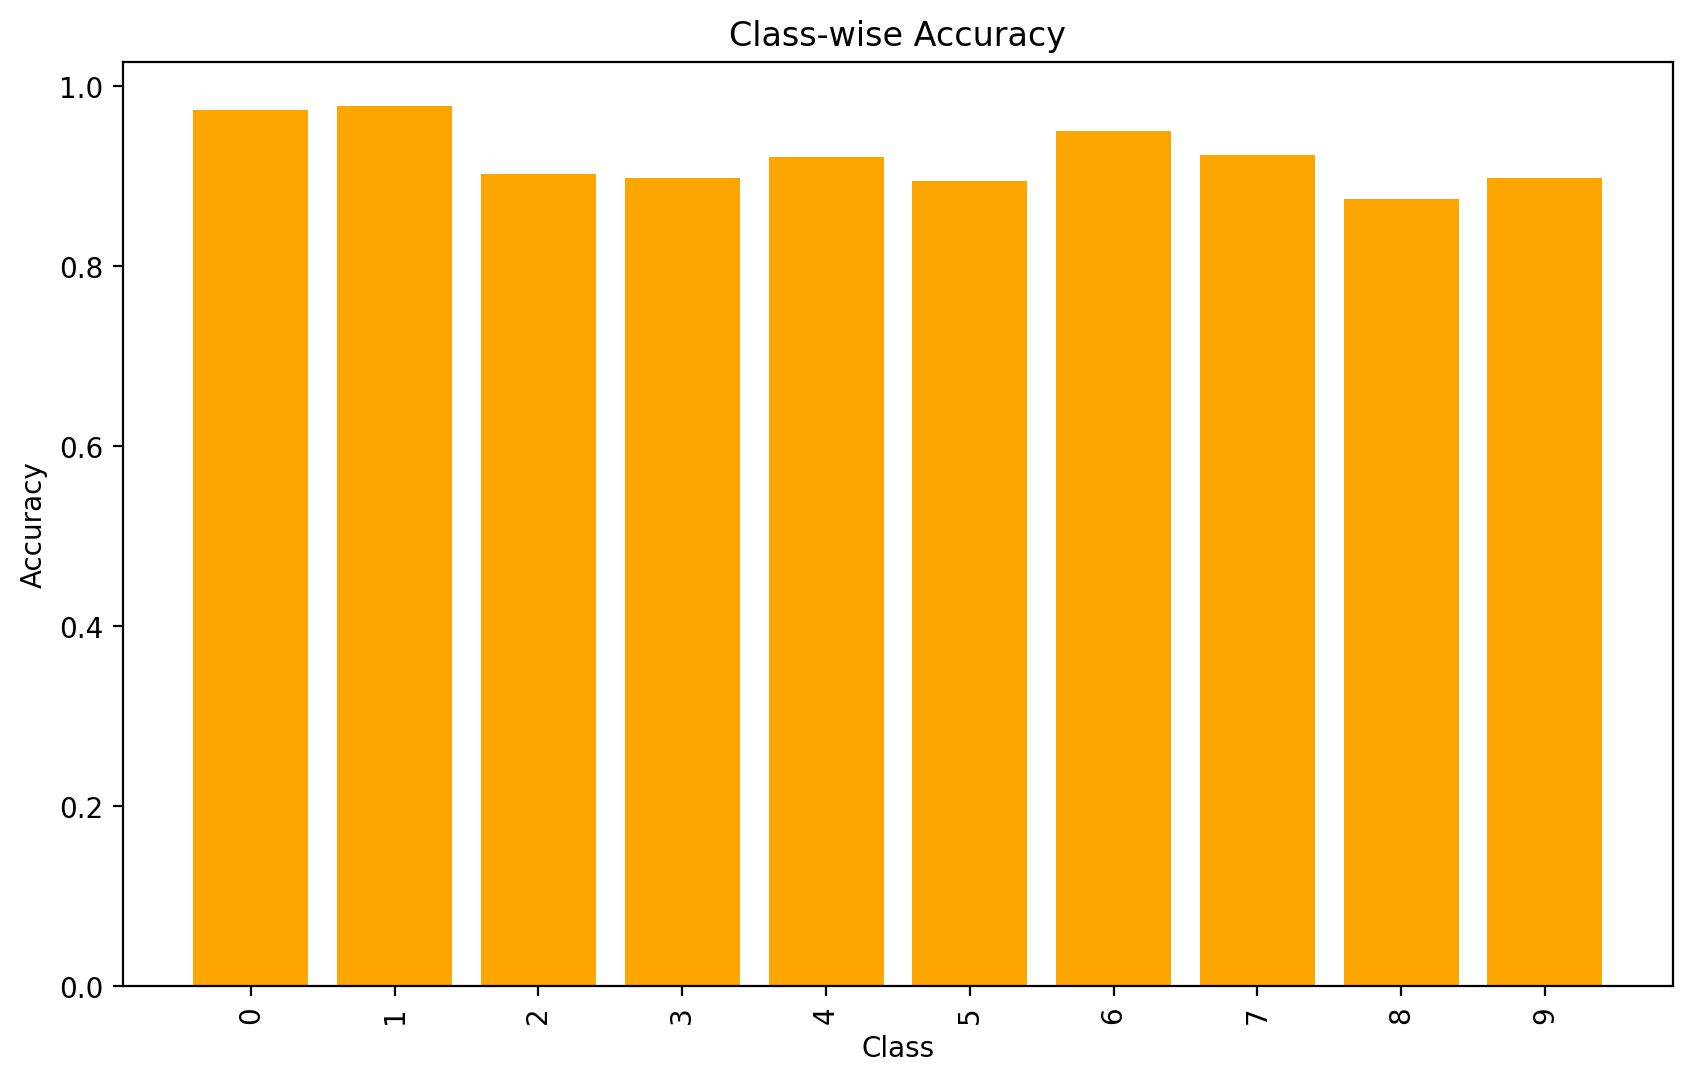

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
def load_mnist():
    dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
    return dataset

# Preprocessing the data (flattening and scaling)
def preprocess_data(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, labels = next(iter(data_loader))
    images = images.view(images.shape[0], -1)  # Flatten the images
    return images.numpy(), labels.numpy()

# Load dataset
dataset = load_mnist()
X, y = preprocess_data(dataset)

# Train-test split using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Class-wise accuracy bar graph
def plot_class_accuracy(y_true, y_pred, class_names):
    class_accuracy = []
    for i in range(len(class_names)):
        true_positive = np.sum((y_true == i) & (y_pred == i))
        total = np.sum(y_true == i)
        class_accuracy.append(true_positive / total if total > 0 else 0)

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracy, color='orange')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=90)
    plt.show()

# Plot results
plot_confusion_matrix(y_test, y_pred, class_names=[str(i) for i in range(10)])
plot_class_accuracy(y_test, y_pred, class_names=[str(i) for i in range(10)])

#If this doesnt work, try following the same steps as the alphabet, get datapath and then make main code


In [ ]:
import os
print("Dataset path contents:", os.listdir(char_dataset))


Dataset path contents: ['EMNIST', 'validation', 'train', 'MNIST', 'test']


In [ ]:
import os
import shutil

# Paths for original and reorganized dataset
char_dataset_path = '/root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1'
target_directory = '/root/alphabet_dataset_structured'  # New structured dataset path

# Inspect the contents of each subfolder
def inspect_dataset(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files[:5]}")
        print()

# Organize dataset into ImageFolder-compatible structure
def restructure_dataset(source_path, target_path):
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    # Look for subdirectories (e.g., train, validation, etc.)
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(source_path, subset)
        if os.path.exists(subset_path):
            for root, dirs, files in os.walk(subset_path):
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg')):  # Handle valid image extensions
                        # Extract the class label from the folder name
                        class_label = os.path.basename(root)
                        class_dir = os.path.join(target_path, subset, class_label)

                        # Create the class directory if it doesn't exist
                        os.makedirs(class_dir, exist_ok=True)

                        # Move the file to the appropriate folder
                        source_file_path = os.path.join(root, file)
                        target_file_path = os.path.join(class_dir, file)
                        shutil.copy2(source_file_path, target_file_path)

    print(f"Dataset restructured and saved at: {target_path}")

# Inspect and restructure the dataset
print("Inspecting original dataset...")
inspect_dataset(char_dataset_path)

print("Restructuring dataset...")
restructure_dataset(char_dataset_path, target_directory)

# Confirm the new structure
print("Inspecting new structured dataset...")
inspect_dataset(target_directory)


Inspecting original dataset...
Directory: /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1
Subdirectories: ['EMNIST', 'validation', 'train', 'MNIST', 'test']
Files: []

Directory: /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1/EMNIST
Subdirectories: ['raw']
Files: []

Directory: /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1/EMNIST/raw
Subdirectories: []
Files: ['gzip.zip', 'emnist-bymerge-train-labels-idx1-ubyte', 'emnist-byclass-train-images-idx3-ubyte', 'emnist-byclass-train-labels-idx1-ubyte', 'emnist-bymerge-train-images-idx3-ubyte']

Directory: /root/.cache/kagglehub/datasets/fayed02/handwritten-isolated-english-character-dataset/versions/1/validation
Subdirectories: ['f', 't', 'k', 'p', 'm', 'q', 'a', 'o', 'e', 'v', 's', 'r', 'h', 'w', 'i', 'l', 'd', 'j', 'y', 'c', 'n', 'b', 'g', 'z', 'x', 'u']
Files: []

Directory: /root/.cache/k

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.47      0.58        66
           1       0.47      0.42      0.44        62
           2       0.55      0.50      0.52        56
           3       0.75      0.59      0.66        71
           4       0.56      0.33      0.41        70
           5       0.59      0.45      0.51        66
           6       0.84      0.70      0.77        44
           7       0.27      0.40      0.32        48
           8       0.52      0.48      0.50        65
           9       0.61      0.45      0.52        60
          10       0.63      0.45      0.53        53
          11       0.38      0.41      0.39        58
          12       0.45      0.39      0.41        75
          13       0.25      0.63      0.35        70
          14       0.35      0.48      0.41        52
          15       0.46      0.49      0.48        53
          16       0.36      0.35      0.36        68
   

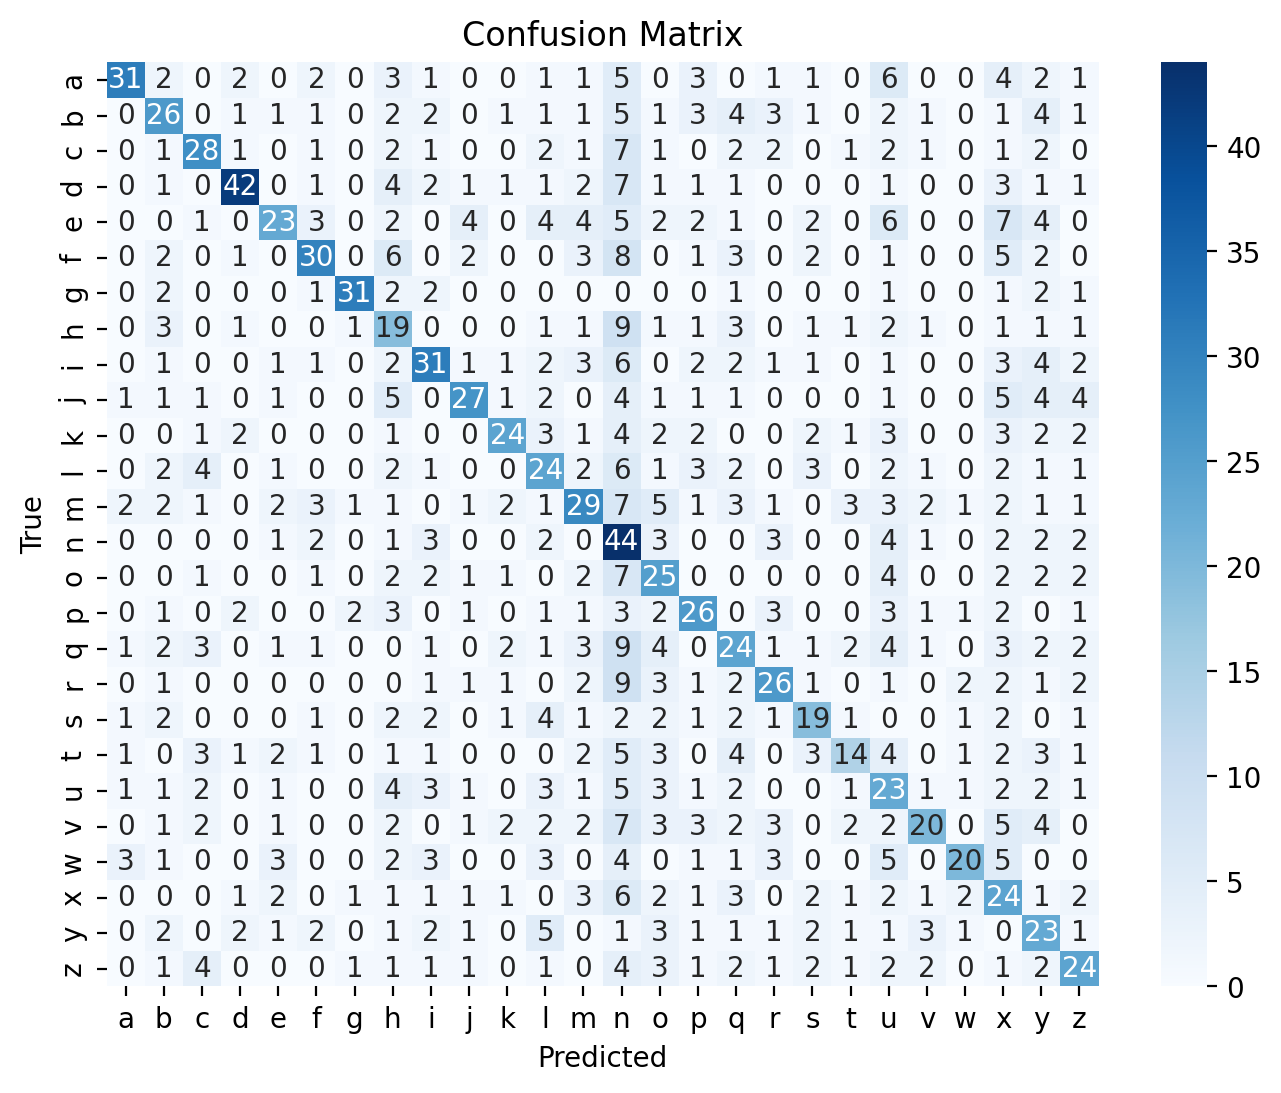

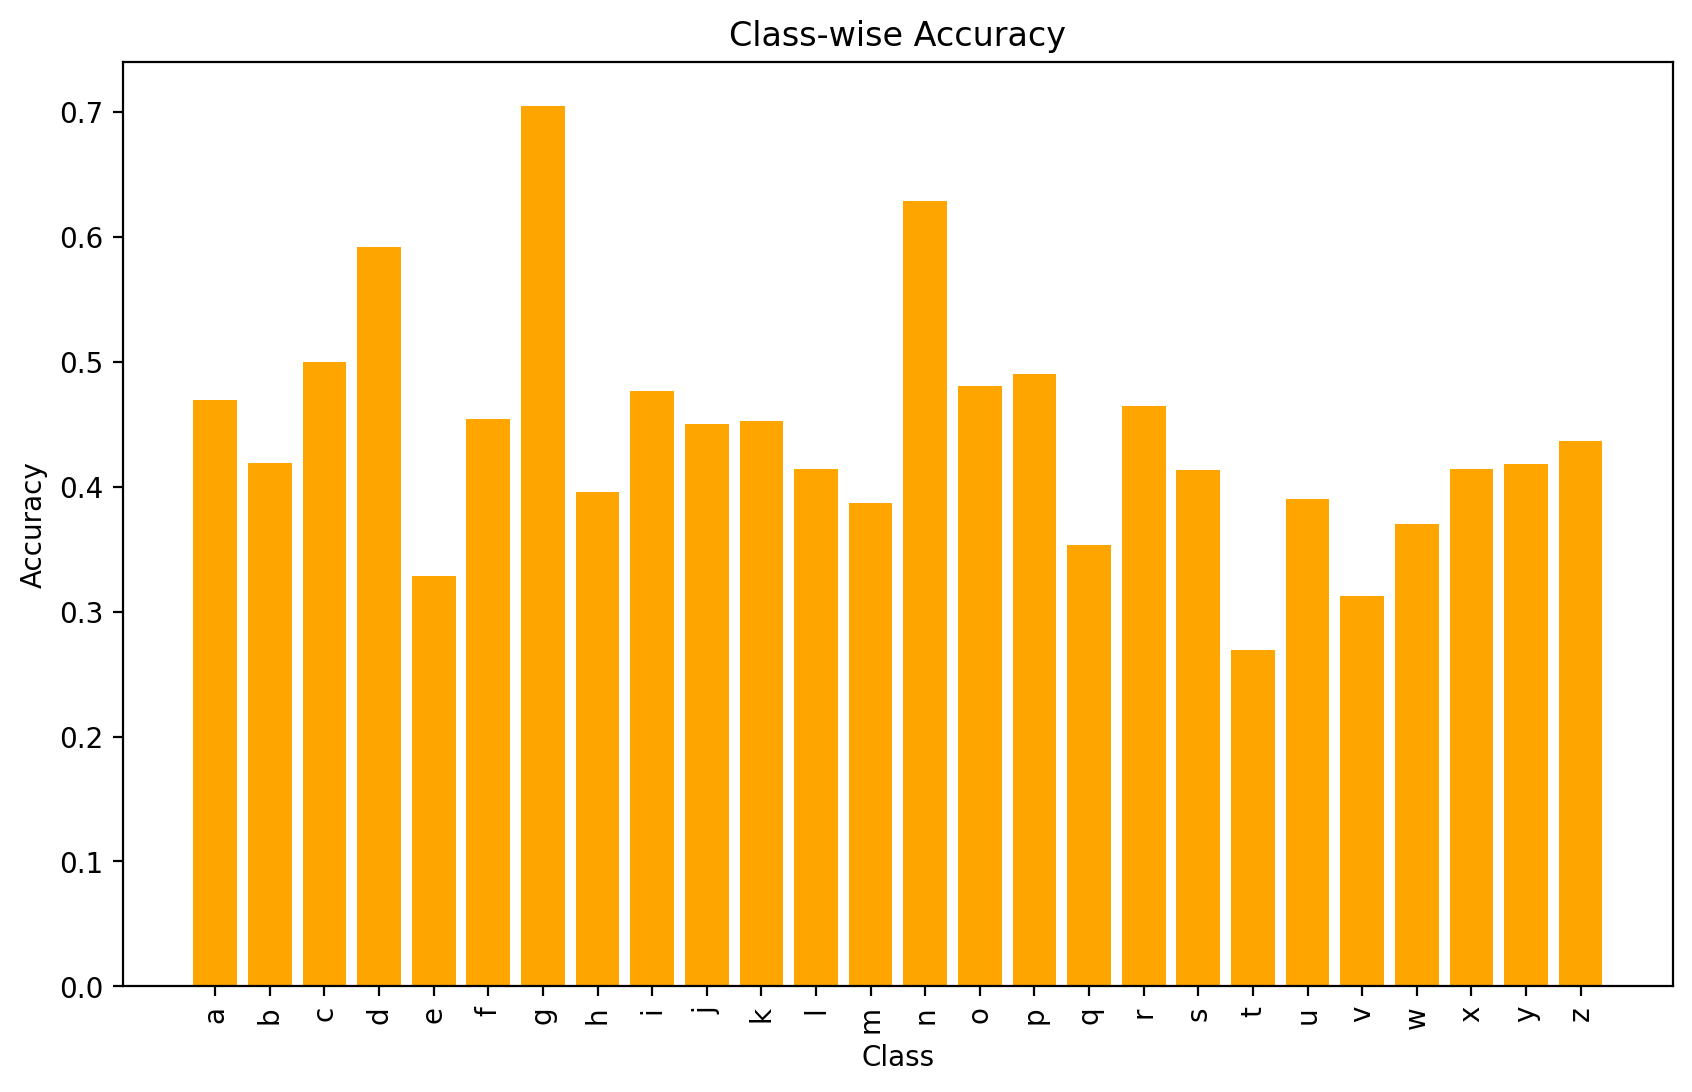

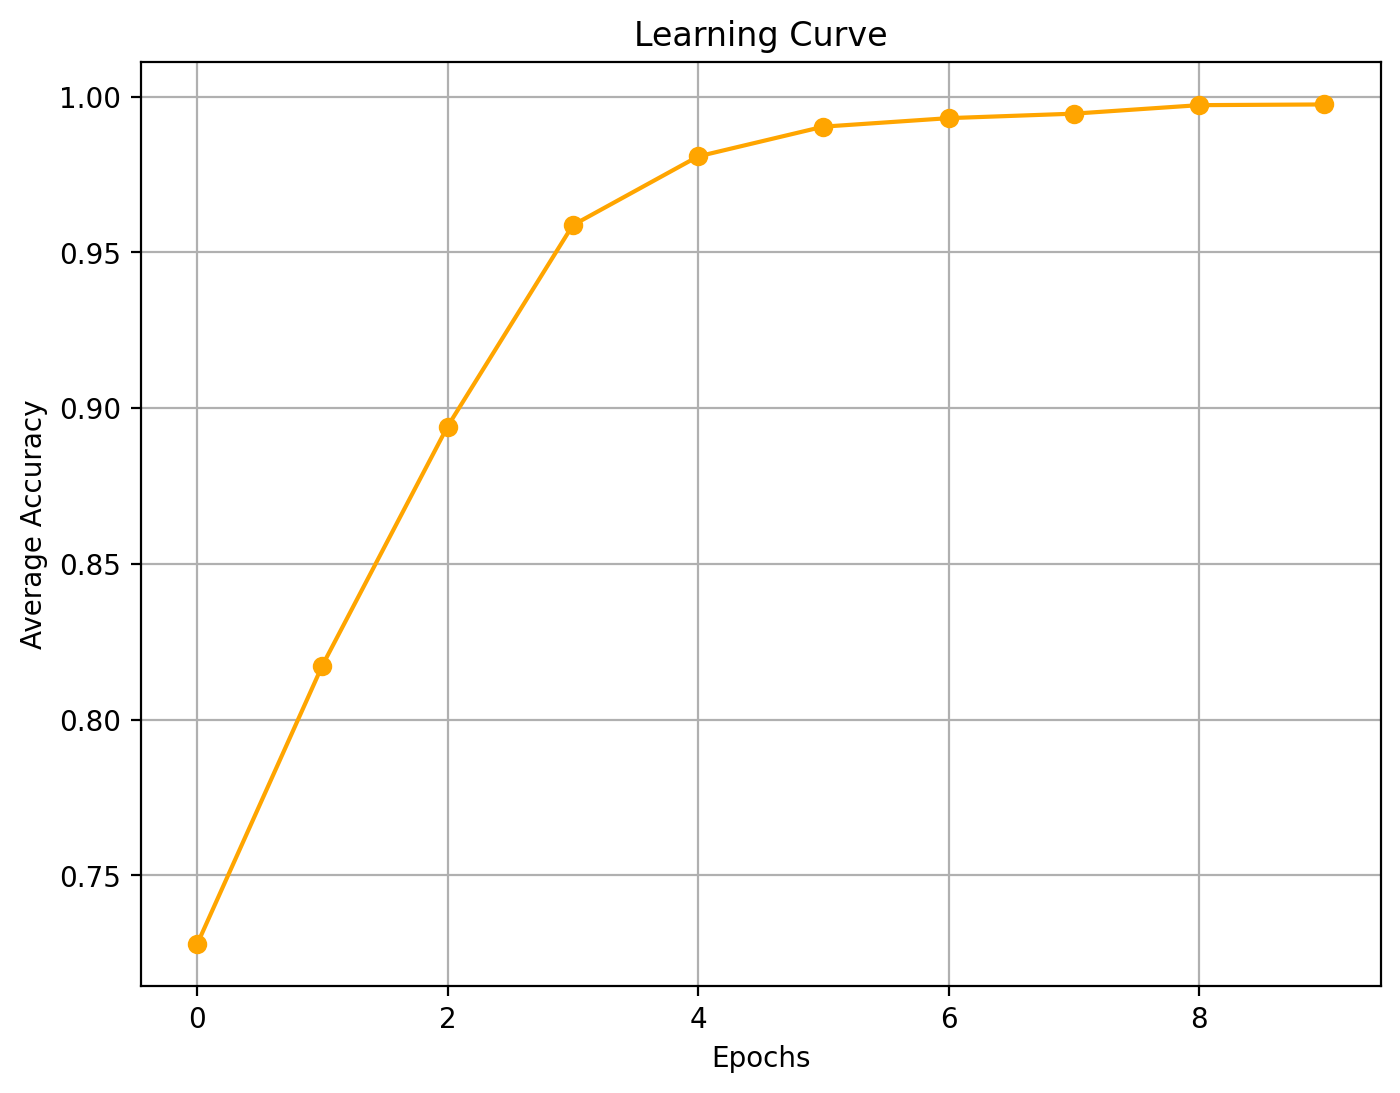

In [ ]:
import numpy as np
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Transformation for images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


def load_alphabet_dataset():
    dataset_path = "/root/alphabet_dataset_structured/train"
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"The path '{dataset_path}' does not exist. Check your dataset.")
    return datasets.ImageFolder(dataset_path, transform=transform)


def train_incremental_svm(data_loader, model, scaler, classes):
    for images, labels in data_loader:
        # Flatten images for SVM compatibility
        images = images.view(images.shape[0], -1).numpy()
        labels = labels.numpy()

        # Scale the batch
        images_scaled = scaler.transform(images)

        model.partial_fit(images_scaled, labels, classes=classes)

dataset = load_alphabet_dataset()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

scaler = StandardScaler()
model = SGDClassifier(loss="hinge", random_state=42)

all_classes = np.unique([label for _, label in dataset])

for images, _ in data_loader:
    images = images.view(images.shape[0], -1).numpy()
    scaler.partial_fit(images)


train_incremental_svm(data_loader, model, scaler, classes=all_classes)


test_dataset_path = "/root/alphabet_dataset_structured/validation"
test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predictions and ground truth
all_preds, all_labels = [], []
for images, labels in test_loader:
    images = images.view(images.shape[0], -1).numpy()
    images_scaled = scaler.transform(images)
    preds = model.predict(images_scaled)
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Accuracy:", accuracy_score(all_labels, all_preds))

# Confusion matrix
def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Class-wise accuracy bar graph
def plot_class_accuracy(all_labels, all_preds, class_names):
    class_accuracy = []
    for i, class_name in enumerate(class_names):
        class_true = np.array(all_labels) == i
        class_pred = np.array(all_preds) == i
        accuracy = np.sum(class_true & class_pred) / np.sum(class_true)
        class_accuracy.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracy, color='orange')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(all_labels, all_preds, dataset.classes)
plot_class_accuracy(all_labels, all_preds, dataset.classes)

# Learning curve by epoch
def plot_learning_curve_epoch(curve_data):
    plt.figure(figsize=(8, 6))
    plt.plot(curve_data, marker='o', linestyle='-', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Average Accuracy")
    plt.title("Learning Curve")
    plt.grid()
    plt.show()


epoch_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    batch_accuracies = []
    for images, labels in data_loader:
        images = images.view(images.shape[0], -1).numpy()
        labels = labels.numpy()
        # Scale images
        images_scaled = scaler.transform(images)

        model.partial_fit(images_scaled, labels, classes=all_classes)


        preds = model.predict(images_scaled)
        batch_accuracies.append(accuracy_score(labels, preds))

    epoch_accuracies.append(np.mean(batch_accuracies))
plot_learning_curve_epoch(epoch_accuracies)


In [ ]:
for images, _ in data_loader:
    print(images.shape)
    break


torch.Size([32, 3, 256, 256])
